# 「日本で最も丸い湖」を探す 💧👌 - 最急降下法による探索


In [1]:
import math
import shutil
import os
from pathlib import Path

import pandas as pd
import geopandas as gpd
import shapely
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from tqdm.notebook import tqdm

In [2]:
OUTPUT_DIR_ROOT = Path("output")
OUTPUT_FINAL_DIR = OUTPUT_DIR_ROOT / "final"
OUTPUT_TRIALS_DIR_ROOT = OUTPUT_DIR_ROOT / "trials"

## データ

`japan.ipynb` で用意したもの:


In [3]:
gdf = gpd.read_file("japan.geojson")
gdf

,湖沼名,行政区域コード,最大水深,水面標高,都道府県,周囲長,面積,円形度,geometry
0,さっぽろ湖,01100,None,None,北海道,17266.599491,1.784306e+06,0.075208,"POLYGON ((1001989.090 4778014.420, 1001986.243..."
1,定山湖,01100,None,None,北海道,12675.560584,1.415566e+06,0.110715,"POLYGON ((1001796.797 4768236.691, 1001796.494..."
2,オタルナイ湖,01203,None,None,北海道,3098.593932,2.998003e+05,0.392385,"POLYGON ((991624.057 4793407.236, 991626.680 4..."
3,春採湖,01206,None,None,北海道,4510.042551,3.485092e+05,0.215309,"POLYGON ((1267613.496 4801427.797, 1267613.309..."
4,富里湖,01208,None,None,北海道,3253.300842,1.978890e+05,0.234954,"POLYGON ((1202955.207 4893685.089, 1202959.210..."
...,...,...,...,...,...,...,...,...,...
551,フンガー湖,47301,None,None,沖縄県,6839.734068,1.368298e+05,0.036755,"POLYGON ((-169172.846 2976897.207, -169177.757..."
552,伊集の湖,47301,None,None,沖縄県,13876.185298,2.817393e+05,0.018387,"POLYGON ((-170469.119 2981102.327, -170467.123..."
553,福上湖,47303,None,None,沖縄県,46528.487906,2.214969e+06,0.012857,"POLYGON ((-174919.821 2966740.620, -174915.221..."
554,新川湖,47303,None,None,沖縄県,5343.803670,1.066351e+05,0.046926,"POLYGON ((-173601.971 2970251.071, -173595.623..."


## 関数


In [4]:
def get_initial_circle_params(lake, area_lake):
    """
    探索の初期値

    中心: バウンディングボックスの中心
    半径: 湖の面積から算出
    """
    x_min, y_min, x_max, y_max = lake.bounds
    center = [(x_min + x_max) / 2, (y_min + y_max) / 2]

    radius = math.sqrt(area_lake / math.pi)

    return center, radius

In [5]:
def calculate_score(lake, circle):
    """
    湖と円の重なり面積の割合
    """
    area_intersection = lake.intersection(circle).area
    area_denominator = max(lake.area, circle.area)
    return area_intersection / area_denominator

In [6]:
def neighbors(center, radius, delta_perc=0.01):
    """
    円を、上下左右に移動させたり、半径を大きくしたり小さくしたりする
    """
    delta = radius * delta_perc

    for cx_move in [-delta, 0, delta]:
        for cy_move in [-delta, 0, delta]:
            for r_move in [-delta, 0, delta]:
                yield ((center[0] + cx_move, center[1] + cy_move), radius + r_move)

In [7]:
FIG_MARGIN = 200


def plot_geoms(lake, circle, score):
    """
    湖と円を重ね合わせてプロット、スコアも表示
    """
    ax = gpd.gpd.GeoSeries([lake, circle]).plot(color=["#1e40af", "#e11d4899"])

    ax.set_axis_off()

    x_min, y_min, x_max, y_max = lake.bounds
    ax.set_xlim(x_min - FIG_MARGIN, x_max + FIG_MARGIN)
    ax.set_ylim(y_min - FIG_MARGIN, y_max + FIG_MARGIN)

    fig = ax.figure
    caption = f"{score:.3f}"
    text = plt.figtext(
        0.5,
        0.5,
        caption,
        wrap=True,
        ha="center",
        va="center",
        fontsize=32,
        color="#1e293b",
    )
    text.set_path_effects(
        [path_effects.withStroke(linewidth=2, foreground="#ffffff44")]
    )

    return fig

In [8]:
N_ITERATIONS = 300


def optimize_circle_score(
    geometry,
    name,
    output_final=True,
    output_trials=False,
):
    if output_trials:
        output_trials_dir = OUTPUT_TRIALS_DIR_ROOT / name
        shutil.rmtree(output_trials_dir, ignore_errors=True)
        os.makedirs(output_trials_dir)

    curr_center, curr_radius = get_initial_circle_params(geometry, geometry.area)
    circle = shapely.geometry.Point(curr_center).buffer(curr_radius)
    curr_score = calculate_score(geometry, circle)

    trial_count = 1
    iter_score = curr_score
    converged = False

    for iter_count in range(1, N_ITERATIONS + 1):
        for nb_center, nb_radius in neighbors(curr_center, curr_radius):
            trial_count += 1

            nb_circle = shapely.geometry.Point(nb_center).buffer(nb_radius)
            nb_score = calculate_score(geometry, nb_circle)

            if nb_score > curr_score:
                curr_score = nb_score
                curr_center = nb_center
                curr_radius = nb_radius
                if output_trials:
                    fig = plot_geoms(geometry, nb_circle, nb_score)
                    fig.savefig(
                        output_trials_dir / f"{trial_count:04d}.png",
                        bbox_inches="tight",
                    )
                    plt.close()

        if curr_score > iter_score:
            iter_score = curr_score
        else:
            converged = True
            break

    best_circle = shapely.geometry.Point(curr_center).buffer(curr_radius)
    best_score = calculate_score(geometry, best_circle)

    if output_final:
        fig = plot_geoms(geometry, best_circle, best_score)
        fig.savefig(OUTPUT_FINAL_DIR / f"{name}.png", bbox_inches="tight")
        plt.close()

    converged_iter_count = iter_count if converged else None
    return best_circle, best_score, converged_iter_count

### 確認


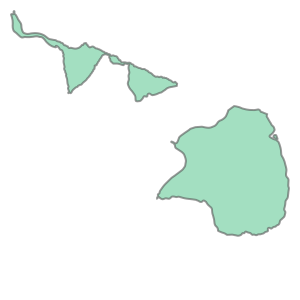

In [9]:
test_index = 18
test_row = gdf.iloc[test_index]

test_name = f"{test_index:03d}_{test_row['湖沼名']}"

test_row.geometry

In [10]:
best_circle, best_score, converged_iter_count = optimize_circle_score(
    test_row.geometry,
    test_name,
    output_final=False,
    output_trials=False,
)

print(converged_iter_count)

129


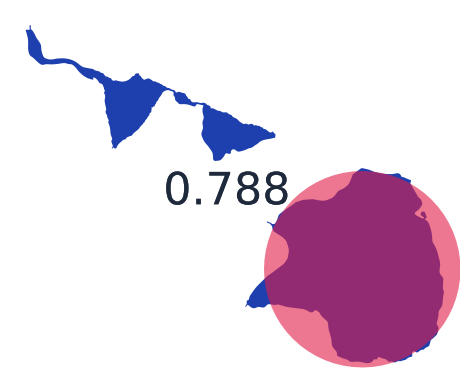

In [11]:
fig = plot_geoms(test_row.geometry, best_circle, best_score)

In [12]:
# 途中経過の画像を出力
optimize_circle_score(
    test_row.geometry,
    test_name,
    output_final=False,
    output_trials=True,  # ←
)

(<POLYGON ((1180278.763 4935827.812, 1180272.76 4935705.623, 1180254.81 49355...>,
 0.7884530584669661,
 129)

## 探索


In [13]:
shutil.rmtree(OUTPUT_FINAL_DIR, ignore_errors=True)
os.makedirs(OUTPUT_FINAL_DIR)

In [14]:
results = []

for gdf_index, row in tqdm(gdf.iterrows(), total=len(gdf)):
    name = f"{gdf_index:03d}_{row['湖沼名']}"
    geometry = row.geometry

    best_circle, best_score, converged_iter_count = optimize_circle_score(
        geometry, name
    )
    results.append((best_circle, best_score, converged_iter_count))

    if converged_iter_count is None:
        print(f"DID NOT CONVERGE: {name}")

  0%|          | 0/556 [00:00<?, ?it/s]

## 集約


In [15]:
df_results = pd.DataFrame(
    results,
    columns=["circle", "score", "converged_iter_count"],
)
df_results

gdf_after = gpd.GeoDataFrame(
    pd.concat([gdf, df_results], axis=1),
)
gdf_after

,湖沼名,行政区域コード,最大水深,水面標高,都道府県,周囲長,面積,円形度,geometry,circle,score,converged_iter_count
0,さっぽろ湖,01100,None,None,北海道,17266.599491,1.784306e+06,0.075208,"POLYGON ((1001989.090 4778014.420, 1001986.243...",POLYGON ((1001978.8571211323 4779212.025196697...,0.418250,79
1,定山湖,01100,None,None,北海道,12675.560584,1.415566e+06,0.110715,"POLYGON ((1001796.797 4768236.691, 1001796.494...",POLYGON ((1002737.9258364028 4768931.369408247...,0.486980,166
2,オタルナイ湖,01203,None,None,北海道,3098.593932,2.998003e+05,0.392385,"POLYGON ((991624.057 4793407.236, 991626.680 4...","POLYGON ((991800.676180113 4793055.6122808205,...",0.632948,65
3,春採湖,01206,None,None,北海道,4510.042551,3.485092e+05,0.215309,"POLYGON ((1267613.496 4801427.797, 1267613.309...",POLYGON ((1267023.4244838692 4800713.634075054...,0.439837,94
4,富里湖,01208,None,None,北海道,3253.300842,1.978890e+05,0.234954,"POLYGON ((1202955.207 4893685.089, 1202959.210...",POLYGON ((1203375.6982420902 4893455.871994682...,0.478131,47
...,...,...,...,...,...,...,...,...,...,...,...,...
551,フンガー湖,47301,None,None,沖縄県,6839.734068,1.368298e+05,0.036755,"POLYGON ((-169172.846 2976897.207, -169177.757...",POLYGON ((-168957.51160687613 2976103.85678853...,0.443417,64
552,伊集の湖,47301,None,None,沖縄県,13876.185298,2.817393e+05,0.018387,"POLYGON ((-170469.119 2981102.327, -170467.123...",POLYGON ((-169937.1355198546 2980661.320203675...,0.207562,30
553,福上湖,47303,None,None,沖縄県,46528.487906,2.214969e+06,0.012857,"POLYGON ((-174919.821 2966740.620, -174915.221...",POLYGON ((-176386.7532515596 2965685.948815732...,0.260268,24
554,新川湖,47303,None,None,沖縄県,5343.803670,1.066351e+05,0.046926,"POLYGON ((-173601.971 2970251.071, -173595.623...",POLYGON ((-173040.97683566905 2969601.81648569...,0.189267,80


## 結果


### 収束にかかったイテレーション数


In [16]:
gdf_after.converged_iter_count.describe()

count    556.000000
mean      56.480216
std       44.884331
min        1.000000
25%       22.000000
50%       45.000000
75%       81.000000
max      275.000000
Name: converged_iter_count, dtype: float64

<Axes: >

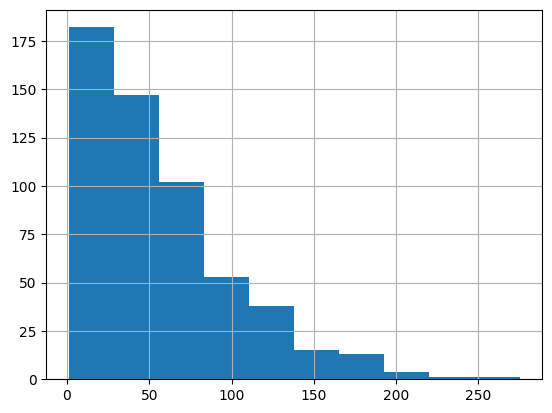

In [17]:
gdf_after.converged_iter_count.hist()

In [18]:
gdf_after.sort_values("converged_iter_count", ascending=False).head(10)

,湖沼名,行政区域コード,最大水深,水面標高,都道府県,周囲長,面積,円形度,geometry,circle,score,converged_iter_count
235,四万湖,10421,None,None,群馬県,3663.334697,8.522150e+04,0.079801,"POLYGON ((839304.634 4060834.701, 839304.799 4...","POLYGON ((839586.4093645954 4059772.081605158,...",0.383884,275
222,東古屋湖,09384,None,None,栃木県,6271.781380,1.383683e+05,0.044204,"POLYGON ((927097.671 4085737.704, 927099.541 4...",POLYGON ((928761.0590028589 4085592.0629089233...,0.483956,241
440,明神湖,28422,None,None,兵庫県,1946.145500,4.898604e+04,0.162529,"POLYGON ((466705.750 3873459.638, 466711.049 3...",POLYGON ((466743.25785548956 3873372.754453714...,0.439226,215
87,伏美湖,01637,None,None,北海道,875.744782,8.872047e+03,0.145371,"POLYGON ((1144433.974 4768165.880, 1144439.638...",POLYGON ((1144478.1140895123 4768091.585724692...,0.434498,206
245,秩父湖,11207,None,None,埼玉県,7646.942272,3.825206e+05,0.082203,"POLYGON ((852068.986 3984357.130, 852065.043 3...",POLYGON ((852687.2896228805 3984324.4650064507...,0.404090,202
502,大原湖,35381,None,None,山口県,10925.986413,8.742182e+05,0.092026,"POLYGON ((193978.769 3799939.468, 194003.697 3...",POLYGON ((192891.90608306922 3798484.249165026...,0.477809,200
387,井川湖,22100,0,700,静岡県,26232.889052,3.726356e+06,0.068046,"POLYGON ((795700.206 3903335.442, 795744.581 3...","POLYGON ((795634.6093598357 3901510.459950164,...",0.436243,192
352,高遠湖,20381,None,None,長野県,3974.660058,2.098587e+05,0.166931,"POLYGON ((777316.426 3968649.199, 777319.121 3...",POLYGON ((777175.8628217318 3969195.3512786827...,0.572480,189
252,円良田湖,"11381,11408",None,None,埼玉県,2597.891687,8.605098e+04,0.160223,"POLYGON ((875261.939 4006656.874, 875262.192 4...","POLYGON ((875277.351410774 4006358.256775352, ...",0.484429,182
324,梓湖,20202,0,980,長野県,27345.223057,2.527258e+06,0.042471,"POLYGON ((740619.461 4004341.489, 740602.350 4...",POLYGON ((744596.6769828878 4001932.5376225165...,0.384273,182


### スコア: 上位


In [19]:
gdf_after.sort_values("score", ascending=False).head(10)[
    ["湖沼名", "円形度", "score", "面積", "周囲長"]
]

,湖沼名,円形度,score,面積,周囲長
69,倶多楽湖,0.945450,0.979780,4.712454e+06,7914.240329
170,田沢湖,0.774597,0.942868,2.587661e+07,20489.001974
362,巣鷹湖,0.902002,0.935432,2.880701e+04,633.505109
175,明月湖,0.954554,0.922862,9.776947e+02,113.450498
547,鰻池,0.859650,0.919971,1.206303e+06,4199.256155
309,南伊奈ヶ湖,0.876669,0.919875,1.380765e+04,444.884269
80,東雲湖（東小沼）,0.920083,0.918454,4.838713e+04,812.935835
51,パンケ沼,0.735632,0.910597,3.566827e+06,7805.769471
118,宇曽利山湖,0.664897,0.906983,2.690288e+06,7130.617201
545,池田湖,0.609720,0.901031,1.095369e+07,15025.180475


In [20]:
gdf_after.sort_values("円形度", ascending=False).head(10)[
    ["湖沼名", "円形度", "score", "面積", "周囲長"]
]

,湖沼名,円形度,score,面積,周囲長
175,明月湖,0.954554,0.922862,9.776947e+02,113.450498
69,倶多楽湖,0.945450,0.979780,4.712454e+06,7914.240329
80,東雲湖（東小沼）,0.920083,0.918454,4.838713e+04,812.935835
314,四尾連湖,0.907386,0.883560,6.753465e+04,967.101981
362,巣鷹湖,0.902002,0.935432,2.880701e+04,633.505109
309,南伊奈ヶ湖,0.876669,0.919875,1.380765e+04,444.884269
547,鰻池,0.859650,0.919971,1.206303e+06,4199.256155
26,橘湖,0.857549,0.842318,9.561053e+04,1183.663517
147,御釜湖,0.812825,0.799363,1.825635e+03,168.001543
146,昭和湖,0.808037,0.882799,2.427759e+03,194.308592


### スコア: 下位


In [21]:
gdf_after.sort_values("score", ascending=True).head(10)[
    ["湖沼名", "円形度", "score", "面積", "周囲長"]
]

,湖沼名,円形度,score,面積,周囲長
50,犬吼湖,0.184268,0.000000,2.275186e+04,1245.627292
30,しのつ湖,0.120419,0.000000,3.135862e+05,5720.526044
538,野尻湖,0.007466,0.066758,1.982224e+06,57759.890301
206,菅生沼,0.015008,0.076171,5.335258e+05,21136.182357
492,阿武湖,0.024432,0.163700,2.948617e+06,38943.689853
427,虹の湖,0.022528,0.164468,1.083538e+06,24584.691031
281,黒又川第一ダム貯水池,0.031294,0.175738,1.253013e+06,22431.062192
499,向道湖,0.065241,0.176915,5.658742e+05,10440.071365
554,新川湖,0.046926,0.189267,1.066351e+05,5343.803670
495,山代湖,0.040926,0.189384,9.123470e+05,16737.349176


In [22]:
gdf_after.sort_values("円形度", ascending=True).head(10)[
    ["湖沼名", "円形度", "score", "面積", "周囲長"]
]

,湖沼名,円形度,score,面積,周囲長
538,野尻湖,0.007466,0.066758,1.982224e+06,57759.890301
553,福上湖,0.012857,0.260268,2.214969e+06,46528.487906
206,菅生沼,0.015008,0.076171,5.335258e+05,21136.182357
42,朱鞠内湖,0.018236,0.707564,2.189462e+07,122831.775969
552,伊集の湖,0.018387,0.207562,2.817393e+05,13876.185298
446,津風呂湖,0.018963,0.397159,1.058867e+06,26489.190921
537,一ツ瀬ダム貯水池,0.018993,0.358358,4.444853e+06,54229.982980
192,奥只見湖,0.019096,0.425380,1.050267e+07,83135.189283
193,田子倉湖,0.019678,0.446872,1.031421e+07,81157.684358
300,九頭竜湖,0.021202,0.360299,7.362565e+06,66058.424862


## ドキュメント


In [23]:
with open("results.md", "w") as fp:
    for rank, (index, row) in enumerate(
        gdf_after.sort_values("score", ascending=False).iterrows(), start=1
    ):
        name = row["湖沼名"]
        fpath = OUTPUT_FINAL_DIR / f"{index:03d}_{row['湖沼名']}.png"
        score = row["score"]
        area = row["面積"]
        perimeter = row["周囲長"]
        circularity = row["円形度"]
        converged_iter_count = row["converged_iter_count"]
        pref = row["都道府県"]

        print(f"## {rank}. {name} （{pref}）", file=fp)
        print(file=fp)
        print(f"- スコア: {score:.3f} （{converged_iter_count} iters）", file=fp)
        print(f"- 円形度: {circularity:.3f}", file=fp)
        print(f"- 面積: {area:,.0f}, 周囲長: {perimeter:,.0f}", file=fp)
        print(file=fp)
        print(f"![{name}]({fpath})", file=fp)
        print(file=fp)